In [1]:
import pickle as pk
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from datetime import datetime
from datetime import timedelta
import thunderfish.pulsetracker as pt
from scipy.signal import fftconvolve
matplotlib.rcParams['font.size'] = 8.0
from scipy.signal import argrelextrema
import matplotlib.cm as cm
import os
import glob

from pulse_tracker import pd, cluster_object

%matplotlib notebook

In [2]:
def RunningMedian(x,N):
    
    result = np.zeros(len(x))
    result[:int(N/2)] = np.nanmedian(x[:int(N/2)])
    result[-int(N/2):] = np.nanmedian(x[-int(N/2):])
    
    idx = np.arange(N) + np.arange(len(x)-N+1)[:,None]
    b = [row[row>0] for row in x[idx]]
    
    try:
        result[int(N/2)-1:-int(N/2)] = np.array([np.nanmedian(c) for c in b])
    except:
        result[int(N/2):-int(N/2)] = np.array([np.nanmedian(c) for c in b])
    return result

In [3]:
def kde_init(sigma, sampling_rate):
    """
    creates the gaussian function which can be used to convolve with the PSTH to create a firing rate graph
    """
    t = np.arange(-4*sigma, 4*sigma, 1 / sampling_rate)
    fxn = np.exp(-0.5 * (t / sigma) ** 2) / np.sqrt(
        2 * np.pi) / sigma  # gaussian function 2.3 (analysis of parallel spike trains)

    return t, fxn

def gaussian_convolve(all_spike_trains, fxn, sampling_rate, avg_opt,trial_length):
    """
    Takes an array of spike trains of different sizes,
    convolves it with a gaussian, returns the average gaussian convolve spikes
    """
    all_convolve_spikes = []
    all_pos = []
    for spike_train in all_spike_trains:
        
        spike_train = spike_train

        # Boolean list in length of trial length, where 1 means spike happened, 0 means no spike
        trial_bool = np.zeros(trial_length)
        spike_indx = (spike_train * sampling_rate).astype(np.int)
        trial_bool[spike_indx] = 1

        # convolve gaussian with boolean spike list
        convolve_spikes = np.asarray(fftconvolve(trial_bool, fxn, mode='same'))
        all_convolve_spikes.append(convolve_spikes)

    return all_convolve_spikes

def fill_gaps(st,isi):
    N=200
    
    # just delete all isis above a certain number
    val4 = RunningMedian(isi,N)
    
    #st[isi>val4*1.5] = np.nan
    isi[isi>val4*1.5] = np.nan
    isi[1/(isi)<10] = np.nan

    return st, isi, val4

def delete_artifacts(st,isi,positions):
    # instead, I can compute runningmedian once and delete values at same idxs as im deleting from the spiketrain.
    # this will make it faster.
    print(np.median(np.abs(np.diff(isi))))
    
    N=100
    # just delete all isis above a certain number
    runmed = RunningMedian(isi,N)
    #plt.figure()
    while True:
        
        # delete these from the spiketrain.
        del_idxs = np.where(isi<runmed*0.7)[0]

        if len(del_idxs) == 0:
            break
        if len(del_idxs) > 1:
            c_del_idxs = del_idxs[np.append([0],np.where(np.diff(del_idxs) > 1)[0]+1)]
        else:
            c_del_idxs = del_idxs

        st = np.delete(st,c_del_idxs)
        runmed = np.delete(runmed,c_del_idxs)
        positions = np.delete(positions,c_del_idxs,axis=0)
        
        isi = np.diff(st)
        
    return st, isi, runmed, positions
    

def combine_clusters(sts):
    
    # try all combinations of the four spiketrains.
    # check if combining reduces the variance.
    # or maybe only the ones with close/overlapping positions
    
    for i,ist in enumerate(sts):
        for j,jst in enumerate(sts[i+1:]):
            if len(np.nonzero(ist)[0]) > 0 and len(np.nonzero(jst)[0]) > 0:
                old_var = np.var(ist[np.nonzero(ist)])
                new_diff = np.diff(np.sort(np.concatenate((ist[np.nonzero(ist)],jst[np.nonzero(jst)]))))
                if np.mean(new_diff)<np.min(old_diff):
                    print('combine clusters %i and %i'%(i,j+i+1))
                    
def del_nan_idx(isi,st,N):
    
    fr = 1/isi
    
    nan_idx = np.where(np.isnan(fr))[0]
    
    if len(nan_idx) > 0:
    
        slices = nan_idx[np.append([0],np.where(np.diff(nan_idx)>1)[0])] - 1
        end_slices = nan_idx[np.append(np.where(np.diff(nan_idx)>1)[0],[len(nan_idx)-2])] + 1
        
        
        slices = st[nan_idx[np.append([0],np.where(np.diff(nan_idx)>1)[0])]]
        end_slices = st[nan_idx[np.append(np.where(np.diff(nan_idx)>1)[0],[len(nan_idx)-2])]+1]

        slice_diff = end_slices - slices
    #    #slice_diff = st[end_slices] - st[slices]
        
        keep_slices_idx = np.where(slice_diff < 30000)[0]

    #    #keep_slices_idx = np.where(slice_diff < N)[0]

    #    keep_idxs = []

        # how do I know the end idx?

        for d in range(len(keep_slices_idx)):
            keep_idxs = np.append(keep_idxs,np.arange(slices[int(d)],end_slices[int(d)]))
    else:
        keep_idxs = np.array([0]) #np.arange(len(isi))

    return keep_idxs
                    
def plot_smooth(spiketimes,isi,N,M):
    
    # delete any fr under 10.
    
    isisList = {}
    stsList = {}
    fisisList = {}
    fstsList = {}
    
    cols = cm.rainbow(np.linspace(0, 1, len(spiketimes.keys())))
    
    plt.figure()
    
    for i,sti in enumerate(spiketimes.keys()):
        if len(spiketimes[sti])>0:
            
            g_idx = np.where(np.isnan(isi[sti])[:-1])[0]
            to_nan_idx = np.where(np.diff(spiketimes[sti])>1)[0]

            del_idx = np.where(np.isnan(isi[sti]))[0]
            
            if True: #len(isi[sti]) - len(del_idx) - len(to_nan_idx) > 20:
                cisi = isi[sti]
                isis = RunningMedian(cisi,N)

                isis[to_nan_idx] = np.nan

                #reinsert nans so it can be seen where the interpolation happened
                plt.plot(spiketimes[sti]/60,1/(isis),alpha=0.5,c=cols[i])

                fisisList[sti] = 1/(isis)
                fstsList[sti] = spiketimes[sti]/60

                isis[del_idx.astype('int')] = np.nan

                plt.plot(spiketimes[sti]/60,1/(isis),c=cols[i])

                isisList[sti] = 1/(isis)
                stsList[sti] = spiketimes[sti]/60
            
    plt.xlabel('time [min]')
    plt.ylabel('EOD frequency [Hz]')
    
    return isisList,fisisList,stsList,fstsList
    #for xc in et:
    #    plt.axvline(x=xc*dt/60,color='k')

    # interpolate rows of nans that are larger than N, otherwise dont plot.

In [4]:
file_count = 0

date = '2019-10-17-19_48'
dati = datetime(2019,10,17,19,48)

path = 'data/results/' + date + '/'

print(os.listdir(path))
file_count = len([n for n in os.listdir(path) if '.pkl' in n])

['0.pkl', 'pics', '1.pkl']


In [5]:
file_count

2

In [6]:
firing_rates = np.zeros((file_count*300*60,4))
fi = 0
et = []
ep = []
st = {}
positions = {}
print(range(fi,fi+file_count))

for i in range(fi,fi+file_count):
    pickle_path = '%s%i.pkl'%(path,i)
    co = pk.load(open(pickle_path,'rb'))

    if len(co.eel.ts[np.nonzero(co.eel.ts)]) > 0:
        et = np.append(et,co.eel.ts[np.nonzero(co.eel.ts)])
        pos = co.eel.positions[np.nonzero(co.eel.positions[:,0]-99)]
        if len(ep) == 0:
            ep = pos
        else:
            ep = np.concatenate((ep,pos))

    if i == 0:
        starttime = co.starttime
    elif i == file_count-1:
        endtime = co.endtime
        dt = co.dt

    #try:
    #    for ci,cl in enumerate(co.clusters):
    #        if cl.label < 5 and cl.label in co.used_labels:
    #            firing_rates[i*300*60:(i+1)*300*60,cl.label-1] = np.stack(co.firing_rates)[np.where(np.asarray(co.used_labels)==cl.label)[0],::100]
    #except:
    idx = []
    used_clusters = []
    used_labels = []
    peakwidth = 20
    
    all_clus = co.clusters
    
    for k,c in all_clus.items():
        if k != 'potential_eod':
            if True: #len(c.ts[np.nonzero(c.ts)]) > 20:
                ts = c.ts[np.nonzero(c.ts)]
                pos = c.positions[np.nonzero(c.ts)]

                if c.label in st:
                    st[c.label] = np.append(st[c.label],ts)
                    positions[c.label] = np.concatenate((positions[c.label],pos))
                else:
                    st[c.label] = ts
                    positions[c.label] = pos

range(0, 2)


In [7]:
et

[]

In [8]:
st_original = st

0.00019999999999242846


/home/colombia/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less


0.00016666666666687036


/home/colombia/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/colombia/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/colombia/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/colombia/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/colombia/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


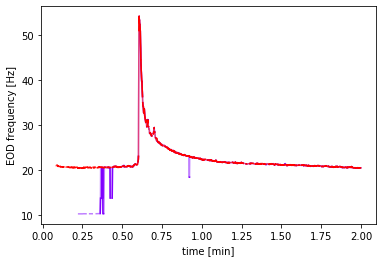

In [9]:
# try this new code to see if this works. if it does I can change the way the spiketrain is edited.
%matplotlib inline
spti = {}
isis = {}
rav = {}

nspti = {}
nisis = {}
nrav = {}

for i,sti in enumerate(st.keys()):
    cst = st[sti]
    cp = positions[sti]
    cisi = np.diff(cst)
    if len(cisi) > 0:
        spti[sti], isis[sti], rav[sti], positions[sti] = delete_artifacts(cst,cisi,cp)
        nspti[sti], nisis[sti], nrav[sti] = fill_gaps(spti[sti][:-1],np.diff(spti[sti]))
        
isis,fisis,sts,fsts = plot_smooth(nspti,nisis,5,1)

In [10]:
if len(et)>0:
    et = et/60

In [11]:
et

[]

0


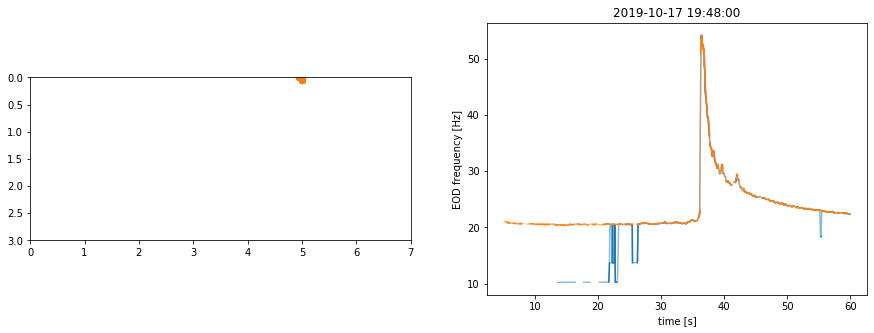

1


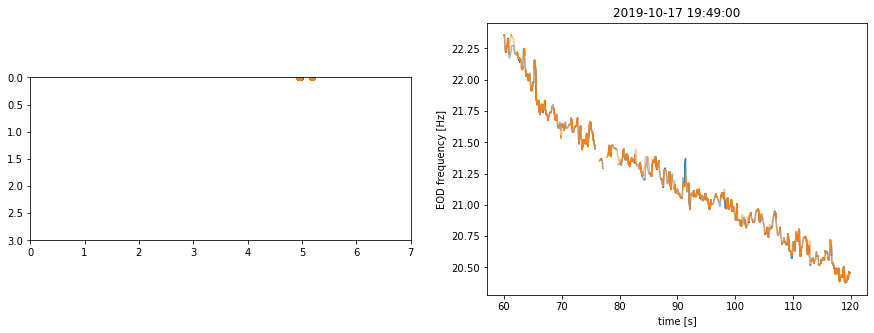

In [12]:
%matplotlib inline
# I should plot timepoints instead...
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for t in np.arange(fi,fi+file_count):
    print(t)
    fig = plt.figure(figsize=(15,5))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    ax1.set_ylim([3,0])
    ax1.set_xlim([0,7])
    ax1.set_aspect('equal')
    
    if len(et)>0:
        ax1.scatter(ep[(et>t) & (et<(t+1)),0],ep[(et>t) & (et<(t+1)),1],color='k',marker='x')

    for i,pk in enumerate(sts.keys()):
        if np.count_nonzero((st[pk]>t*60) & (st[pk]<(t+1)*60)) > 1:
            
            p = positions[pk][:-1]
                    
            x = sts[pk]
            y = isis[pk]
            fx = fsts[pk]
            fy = fisis[pk]
            
            ax1.scatter(p[(x>t) & (x<(t+1)) & (~np.isnan(y)),1],p[(x>t) & (x<(t+1)) & (~np.isnan(y)),0],alpha=0.5,color=colors[i%len(colors)])
            #ax1.scatter(p[(x>t) & (x<(t+1)),1],p[(x>t) & (x<(t+1)) ,0],alpha=0.5,color=colors[i%len(colors)])


            ax2.plot(x[(x>t) & (x<t+1)]*60,y[(x>t) & (x<t+1)],color=colors[i%len(colors)])
            ax2.plot(fx[(fx>t) & (fx<t+1)]*60,fy[(fx>t) & (fx<t+1)],alpha=0.5,color=colors[i%len(colors)])

    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('EOD frequency [Hz]')

    if len(et) > 0 and len(et[(et>t) & (et<t+1)]) > 0:
        for xc in et[(et>t) & (et<t+1)]:
            plt.axvline(x=xc*60,color='k')

    directory = path + 'pics/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.title('%s'%(dati + timedelta(0,0,0,0,int(t))))
    plt.savefig('%s%i.png'%(directory,t))
    plt.show()

In [13]:
co.clusters.keys()

dict_keys(['potential_eod', '1', '2'])